In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')
print(os.get_exec_path())

['/home/tm_ba/miniconda3/envs/BA/bin', '/home/tm_ba/miniconda3/condabin', '/opt/ros/noetic/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin']


In [3]:
import pandas as pd
import os

def parse_and_merge_tables(file_paths):
    """
    Parses the tables from the given list of files and merges tables of the same kind.

    Args:
        file_paths (list): List of paths to the files containing the tables.

    Returns:
        dict: A dictionary where the keys are table names, and the values are merged DataFrames.
    """
    # Initialize a dictionary to store DataFrames with table names as keys
    merged_tables = {}
    to_delete = []

    for recording_idx, file_path in enumerate(file_paths):
        with open(file_path, 'r') as file:
            # Read the entire content of the file
            content = file.read()

        # Split the content by double newlines to separate the tables
        tables = content.strip().split('\n\n')

        for table in tables:
            # Split the table content by lines
            lines = table.strip().split('\n')

            # Extract the table name from the first line
            table_name = lines[0].strip()

            # Extract the Hz information (metadata) from the second line
            hz = lines[1].strip()

            # Parse the column headers and units from the next three lines
            group_headers = lines[2].split(',')  # Group headers (first row)
            column_headers = lines[3].split(',')  # Column names (second row)
            units = lines[4].split(',')  # Units (third row)

            # Create a list to hold the full column names
            columns = []
            current_group = ""

            # Construct the full column names using group headers, column names, and units
            for group_header, column_header, unit in zip(group_headers, column_headers, units):
                if group_header.strip():  # Update the current group if it's not empty
                    current_group = group_header.strip()
                    if ":" in current_group:
                        current_group = current_group.split(":")[1]
                full_column_name = ""
                if current_group:
                    full_column_name = f"{current_group}:"
                full_column_name += f"{column_header.strip()}"
        
                columns.append(full_column_name)
            

            # Parse the data rows starting from the 6th line onward
            data = [line.split(',') for line in lines[5:]]

            # Create a DataFrame for the current table
            df = pd.DataFrame(data, columns=columns)

            # Convert numeric columns to appropriate types where possible
            df = df.apply(pd.to_numeric)

            # Attach metadata (Hz information) to the DataFrame as an attribute
            df.attrs['hz'] = hz

            # Check for duplicate column names and handle them by renaming
            if len(df.columns) != len(set(df.columns)):
                # Automatically renames duplicate columns
                df.columns = pd.io.parsers.ParserBase({'names': df.columns})._maybe_dedup_names(df.columns)
                to_delete.append(file_path)

            if table_name == "Trajectories":
                wanted_columns = ["Frame", "shoulder", "elbow", "wrist", "ThumbTip"]
                columns = [col for col in columns if (":" not in col and col in wanted_columns) or (":" in col and col.split(":")[0] in wanted_columns)]

            df = df.loc[:, columns]

            # Add 'Sequence' column to track the file source
            df['Sequence'] = recording_idx

            # If the table has already been seen, merge the new data into the existing DataFrame
            if table_name in merged_tables:
                existing_df = merged_tables[table_name]

                # Align columns before concatenation
                merged_tables[table_name] = pd.concat([existing_df, df], ignore_index=True)
            else:
                merged_tables[table_name] = df

    # Optionally, remove files with duplicate column names
    for csv in to_delete:
        os.remove(csv)

    return merged_tables


In [4]:
data_directory  = "Mathew" 
data_paths = [os.path.join(data_directory, data_path) for data_path in os.listdir(data_directory)]
tables_dict = parse_and_merge_tables(data_paths)


In [5]:
# Display the tables in the dictionary
for table_name, df in tables_dict.items():
    print(f"Table Name: {table_name}")
    print(f"Hz: {df.attrs['hz']}")
    print(f"Columns: {df.columns}")
    os.makedirs('csv_new', exist_ok=True)
    df.to_csv(f"csv_new/{table_name}.csv", index=False)  # Save the DataFrame to a CSV file
    print("\n" + "-"*50 + "\n")  # Separator between tables

Table Name: Joints
Hz: 200
Columns: Index(['Frame', 'Sub Frame', 'HandOuter_Thumb:RX', 'HandOuter_Thumb:RY',
       'HandOuter_Thumb:RZ', 'LowerArm_HandOuter:RX', 'LowerArm_HandOuter:RY',
       'LowerArm_HandOuter:RZ', 'UpperArm_LowerArm:RX', 'UpperArm_LowerArm:RY',
       'UpperArm_LowerArm:RZ', 'World_UpperArm:RX', 'World_UpperArm:RY',
       'World_UpperArm:RZ', 'World_UpperArm:TX', 'World_UpperArm:TY',
       'World_UpperArm:TZ', 'Sequence'],
      dtype='object')

--------------------------------------------------

Table Name: Segments
Hz: 200
Columns: Index(['Frame', 'Sub Frame', 'HandOuter:RX', 'HandOuter:RY', 'HandOuter:RZ',
       'HandOuter:TX', 'HandOuter:TY', 'HandOuter:TZ', 'LowerArm:RX',
       'LowerArm:RY', 'LowerArm:RZ', 'LowerArm:TX', 'LowerArm:TY',
       'LowerArm:TZ', 'Thumb:RX', 'Thumb:RY', 'Thumb:RZ', 'Thumb:TX',
       'Thumb:TY', 'Thumb:TZ', 'UpperArm:RX', 'UpperArm:RY', 'UpperArm:RZ',
       'UpperArm:TX', 'UpperArm:TY', 'UpperArm:TZ', 'Sequence'],
      dtyp

In [6]:
trajectories = tables_dict["Trajectories"]
trajectories

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
0,1,424.573,31.46390,632.820,437.244,95.0522,303.700,326.770,203.019,98.6228,208.065,226.836,58.5300,0
1,2,424.260,31.44500,632.718,436.375,95.5444,304.092,324.475,203.747,100.3170,205.831,226.619,58.8733,0
2,3,424.073,31.44570,632.837,435.643,96.2625,304.070,NaN,NaN,NaN,203.393,225.856,59.2708,0
3,4,423.898,31.59660,632.891,434.516,96.9949,304.057,NaN,NaN,NaN,200.365,225.176,59.9573,0
4,5,423.604,31.65990,632.974,433.747,97.6751,303.587,NaN,NaN,NaN,197.646,224.697,60.5265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,472.782,-7.33897,652.253,554.699,35.5385,328.978,590.940,176.447,116.2500,553.403,289.602,36.5813,50
29036,485,472.814,-7.35831,652.198,554.922,35.4013,329.154,591.052,176.461,116.3110,553.230,289.540,36.6210,50
29037,486,472.883,-7.35738,652.159,555.211,35.2621,329.311,591.054,176.543,116.2950,553.066,289.457,36.4266,50
29038,487,472.944,-7.36919,652.078,555.527,35.0052,329.505,NaN,NaN,NaN,552.995,289.511,36.4619,50


/tmp/ipykernel_295937/2545848900.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sequence_counts.index, y=sequence_counts.values, palette='viridis')


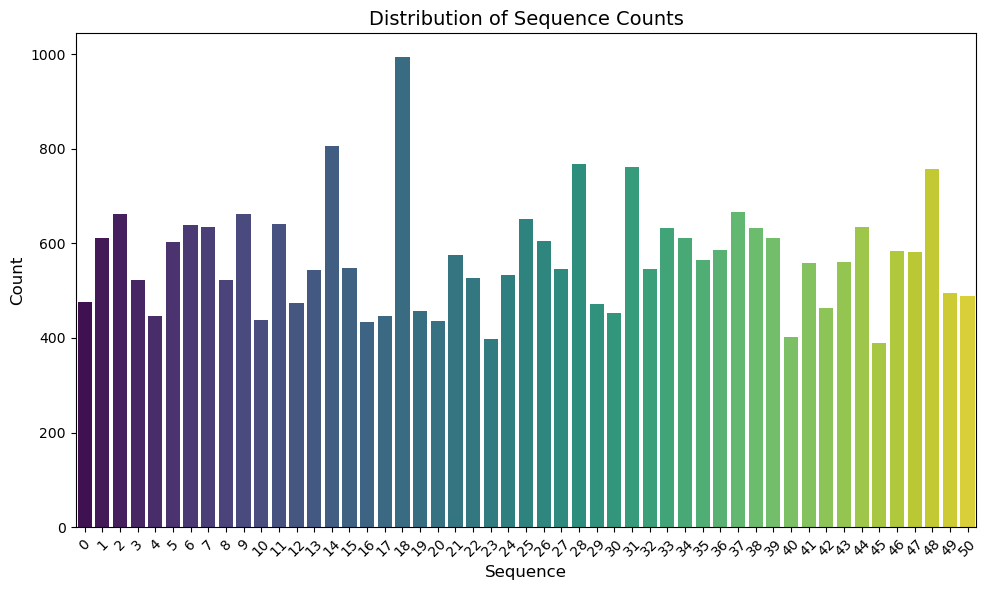

In [7]:

# Get the sequence counts
sequence_counts = trajectories["Sequence"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sequence_counts.index, y=sequence_counts.values, palette='viridis')

# Add title and labels
plt.title('Distribution of Sequence Counts', fontsize=14)
plt.xlabel('Sequence', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate the x-axis labels if there are many sequences
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [8]:
num_landmarks = (trajectories.shape[1] - 2) // 3 
num_landmarks

4

In [9]:
def plot_joint_speeds(df, sequence_idx, max_frames=None):
    """
    Plots the speed of various joints over time for a specified sequence.

    Parameters:
    df (pd.DataFrame): DataFrame containing the trajectory data with columns for each joint's X, Y, Z positions.
    sequence_idx (int): The sequence index to filter the data and visualize.
    max_frames (int, optional): Maximum number of frames to display for clarity. If None, it will display all frames.

    Returns:
    None: Displays the plot.
    """
    # Step 1: Identify joint names based on column names containing ':X', ':Y', ':Z'
    joint_names = set([col.split(':')[0] for col in df.columns if ':' in col])

    # Step 2: Filter the data by the specified sequence index
    filtered_data = df[df["Sequence"] == sequence_idx].copy()

    # Step 3: Limit the number of frames for clarity if max_frames is specified
    if max_frames is not None:
        filtered_data = filtered_data.iloc[:max_frames]

    # Step 4: Calculate speed for each joint
    for joint in joint_names:
        x_col = f'{joint}:X'
        y_col = f'{joint}:Y'
        z_col = f'{joint}:Z'
        
        # Make sure the joint has X, Y, and Z columns before calculating speed
        if all(col in filtered_data.columns for col in [x_col, y_col, z_col]):
            filtered_data[f'{joint}_speed'] = np.sqrt(filtered_data[x_col].diff()**2 + 
                                           filtered_data[y_col].diff()**2 + 
                                           filtered_data[z_col].diff()**2)

    # Step 5: Plot the speeds of each joint
    plt.figure(figsize=(12, 8))
    
    # Plot all calculated speed columns
    for joint in joint_names:
        speed_col = f'{joint}_speed'
        if speed_col in filtered_data.columns:  # Check if the speed column exists
            plt.plot(filtered_data.index, filtered_data[speed_col], label=f'{joint} Speed')
    
    # Add labels and title
    plt.title(f'Speed of Various Joints Over Time (Sequence {sequence_idx})')
    plt.xlabel('Frame')
    plt.ylabel('Speed (units/frame)')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

In [10]:
recording_idx = 0

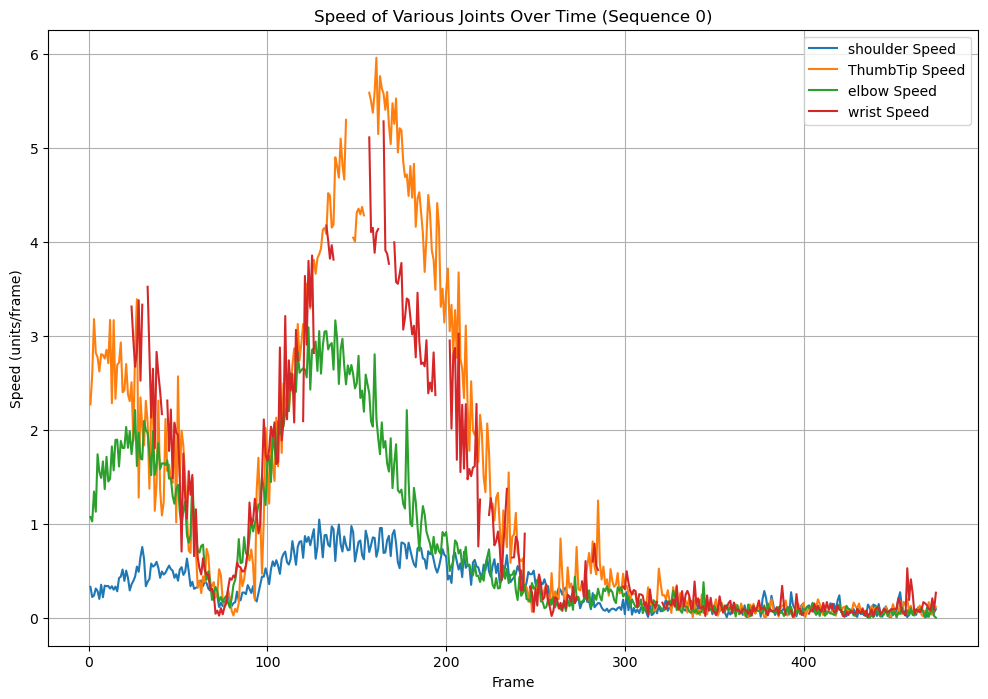

In [11]:
plot_joint_speeds(trajectories, recording_idx)


### Filling NaN values

In [12]:
trajectories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frame       29040 non-null  int64  
 1   shoulder:X  29040 non-null  float64
 2   shoulder:Y  29040 non-null  float64
 3   shoulder:Z  29040 non-null  float64
 4   elbow:X     28855 non-null  float64
 5   elbow:Y     28855 non-null  float64
 6   elbow:Z     28855 non-null  float64
 7   wrist:X     21929 non-null  float64
 8   wrist:Y     21929 non-null  float64
 9   wrist:Z     21929 non-null  float64
 10  ThumbTip:X  28985 non-null  float64
 11  ThumbTip:Y  28985 non-null  float64
 12  ThumbTip:Z  28985 non-null  float64
 13  Sequence    29040 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 3.1 MB


In [13]:
trajectories_interpolated = trajectories.copy()

for sequence in trajectories["Sequence"].drop_duplicates():
  
    trajectories_interpolated[trajectories_interpolated["Sequence"] == sequence] = trajectories_interpolated[trajectories_interpolated["Sequence"] == sequence].interpolate(method='linear', limit_direction="both")


# Display the number of NaN values in each column after interpolation
print("Remaining NaN values in each column after interpolation:")
print(trajectories_interpolated.isna().sum())


Remaining NaN values in each column after interpolation:
Frame         0
shoulder:X    0
shoulder:Y    0
shoulder:Z    0
elbow:X       0
elbow:Y       0
elbow:Z       0
wrist:X       0
wrist:Y       0
wrist:Z       0
ThumbTip:X    0
ThumbTip:Y    0
ThumbTip:Z    0
Sequence      0
dtype: int64


In [14]:
trajectories_interpolated[trajectories_interpolated["Sequence"] == 10]

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
5777,1,433.257,25.94140,636.579,446.079,96.1175,307.585,296.813,218.434,124.319,243.561,277.057,66.9528,10
5778,2,433.026,26.03820,636.504,445.154,96.5215,307.336,296.813,218.434,124.319,239.350,276.398,67.8125,10
5779,3,432.704,26.03570,636.345,444.320,96.9313,307.213,296.813,218.434,124.319,235.942,276.499,70.0076,10
5780,4,432.423,26.11300,636.347,443.482,97.4989,307.048,296.813,218.434,124.319,232.011,275.962,72.6327,10
5781,5,432.116,26.33690,636.295,442.674,98.2479,307.396,296.813,218.434,124.319,228.578,276.036,74.9239,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,433,478.181,-6.78143,635.781,557.088,37.8702,321.603,587.598,188.585,111.592,549.871,300.157,33.1626,10
6210,434,478.191,-6.78501,635.785,557.100,37.8758,321.610,587.593,188.618,111.645,550.445,300.336,34.0615,10
6211,435,478.160,-6.80879,635.800,557.147,37.7945,321.711,587.590,188.640,111.557,550.172,300.345,33.8011,10
6212,436,478.171,-6.78700,635.760,557.228,37.8177,321.666,587.643,188.639,111.674,549.877,300.196,33.1641,10


In [15]:
trajectories_interpolated[trajectories_interpolated["Sequence"].isin([10,11,12,15])].mean()

Frame         268.615531
shoulder:X    458.310626
shoulder:Y    -22.519181
shoulder:Z    612.144743
elbow:X       509.541174
elbow:Y        40.181817
elbow:Z       295.599584
wrist:X       469.231028
wrist:Y       198.477754
wrist:Z       130.524359
ThumbTip:X    405.309936
ThumbTip:Y    285.747792
ThumbTip:Z     63.271754
Sequence       12.061934
dtype: float64

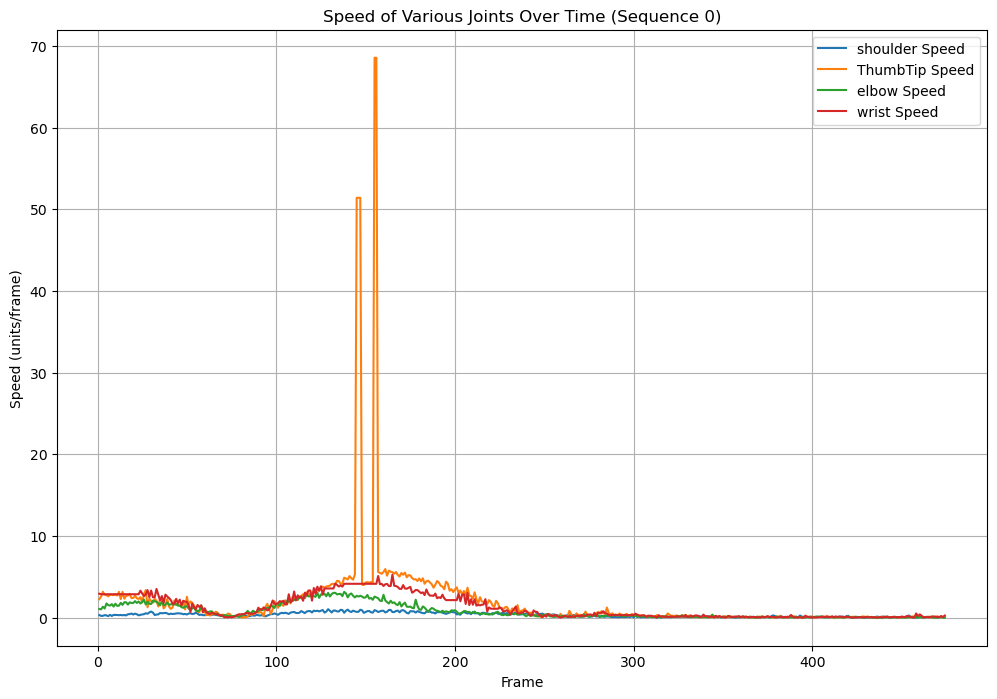

In [16]:
plot_joint_speeds(trajectories_interpolated, 0)

In [17]:
import pandas as pd
import numpy as np

# Function to calculate relative madness
def relative_madness(x):
    return abs(x[1] - np.median(x)) - np.median(np.abs(x - np.median(x)))

def clean_motion_data_with_mad(df, window=3, mad_threshold=2):
    # Get joint columns based on the ":" symbol
    joint_columns = [col for col in df.columns if ":" in col]
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    # Process each joint column separately
    for joint_col in joint_columns:
        # Apply a rolling window to calculate the relative madness
        df_cleaned[f'Madness_{joint_col}'] = (
            df_cleaned[joint_col].rolling(window=window, center=True)
            .apply(relative_madness, raw=True)
        )
        
        # Detect spikes based on the MAD threshold
        df_cleaned[f'Spike_{joint_col}'] = df_cleaned[f'Madness_{joint_col}'] > mad_threshold

        # Replace outliers (spikes) with NaN
        df_cleaned.loc[df_cleaned[f'Spike_{joint_col}'], joint_col] = np.nan
    
    # Interpolate the missing values (spikes)
    df_cleaned.interpolate(method='linear', inplace=True)
    
    # Drop the intermediate Madness and Spike columns
    df_cleaned.drop(columns=[col for col in df_cleaned.columns if 'Madness_' in col or 'Spike_' in col], inplace=True)
    
    return df_cleaned

# Example usage:
# cleaned_df = clean_motion_data_with_mad(your_dataframe)


In [18]:
trajectories_cleaned = clean_motion_data_with_mad(trajectories_interpolated, window=20, mad_threshold=1)

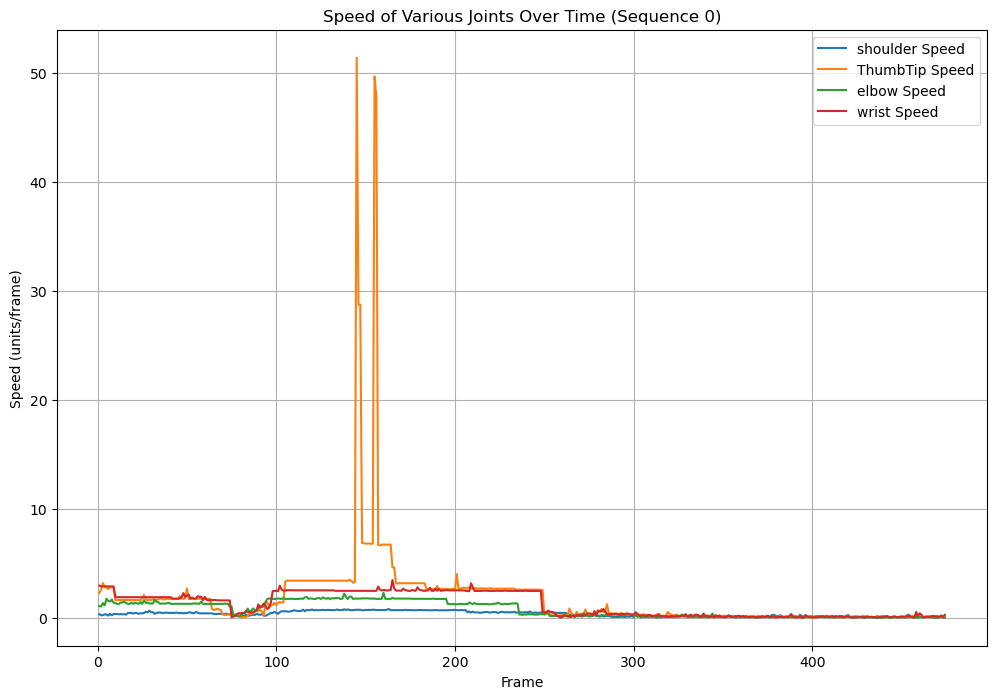

In [19]:
plot_joint_speeds(trajectories_cleaned, 0)


In [20]:
def clean_motion_data(df, k=3, method='mad', interpolation_method='linear', window_size=1, min_velocity=0.001):
    """
    Cleans human motion tracking data by detecting and correcting outliers based on velocity spikes
    for each sequence independently.

    Parameters:
    df (DataFrame): The input DataFrame containing motion tracking data, including a "Sequence" column.
    k (int or float): Multiplier for outlier detection threshold (default: 3).
    method (str): Method for outlier detection, 'mad' for Median Absolute Deviation, 'std' for Standard Deviation (default: 'mad').
    interpolation_method (str): Method for interpolation, e.g., 'linear', 'polynomial', 'spline' (default: 'linear').
    window_size (int): Window size for calculating velocity (default: 1, no smoothing).
    min_velocity (float): Minimum detectable velocity to ignore noise (default: 0.001).

    Returns:
    DataFrame: The cleaned DataFrame with outliers corrected via interpolation.
    """


    # Create an empty list to hold the cleaned DataFrames for each sequence
    cleaned_dfs = []
    
    # Get the unique sequence values
    sequences = df['Sequence'].unique()

    # Loop over each unique sequence
    for sequence in sequences:
        # Extract the sub-DataFrame for the current sequence
        df_seq = df[df['Sequence'] == sequence].copy()

        # List of joints to process
        joints = ['shoulder', 'elbow', 'wrist', 'ThumbTip']

        # Loop over each joint to detect outliers and clean the data
        for joint in joints:
            # Compute differences between consecutive frames for each coordinate
            dx = df_seq[f'{joint}:X'].diff()
            dy = df_seq[f'{joint}:Y'].diff()
            dz = df_seq[f'{joint}:Z'].diff()

            # Compute velocity magnitude (Euclidean distance of position differences)
            velocity = np.sqrt(dx**2 + dy**2 + dz**2)

            # Optional: Apply rolling window for velocity smoothing
            if window_size > 1:
                velocity = velocity.rolling(window=window_size, min_periods=1).mean()

            # Remove small velocities that are below the noise threshold
            velocity[velocity < min_velocity] = 0
            
            # Exclude NaN velocities from statistics
            velocity_nonan = velocity.dropna()

            # Detect outliers using the specified method
            if method == 'mad':
                # Compute median and MAD
                median_velocity = velocity_nonan.median()
                mad_velocity = np.median(np.abs(velocity_nonan - median_velocity))
                if mad_velocity == 0:
                    # Fallback to standard deviation if MAD is zero
                    std_velocity = velocity_nonan.std()
                    threshold = median_velocity + k * std_velocity
                else:
                    threshold = median_velocity + k * mad_velocity
            elif method == 'std':
                # Compute mean and standard deviation
                mean_velocity = velocity_nonan.mean()
                std_velocity = velocity_nonan.std()
                threshold = mean_velocity + k * std_velocity
            else:
                raise ValueError("Method must be 'mad' or 'std'.")

            # Identify outlier indices where velocity exceeds the threshold
            outlier_indices = velocity > threshold

            # Mark the positions at those frames as NaN for interpolation
            df_seq.loc[outlier_indices, [f'{joint}:X', f'{joint}:Y', f'{joint}:Z']] = np.nan

        # Interpolate over NaN values to ensure smooth transitions across the time sequence
        df_seq.interpolate(method=interpolation_method, inplace=True)
        
        # Append the cleaned sequence DataFrame to the list
        cleaned_dfs.append(df_seq)

    # Concatenate all cleaned sub-DataFrames back into a single DataFrame
    cleaned_df = pd.concat(cleaned_dfs).sort_index()

    return cleaned_df


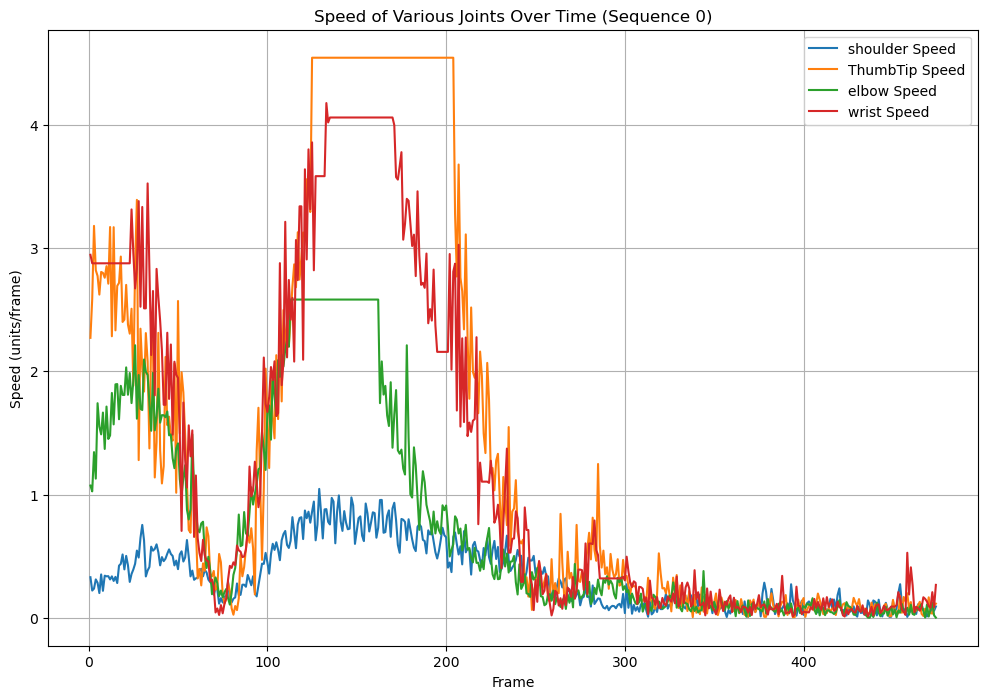

In [21]:
trajectories_cleaned = clean_motion_data(trajectories_interpolated, k=8, method='mad', interpolation_method='linear', window_size=5, min_velocity=0.01)

plot_joint_speeds(trajectories_cleaned, 0)

In [22]:
def plot_joint_speeds_compare(df_original, df_smoothed, sequence_idx, joint_names=None, max_frames=None):
    """
    Plots the original and smoothed speed of various joints over time for a specified sequence.

    Parameters:
    df_original (pd.DataFrame): DataFrame containing the original trajectory data with columns for each joint's X, Y, Z positions.
    df_smoothed (pd.DataFrame): DataFrame containing the smoothed trajectory data with columns for each joint's X, Y, Z positions.
    sequence_idx (int): The sequence index to filter the data and visualize.
    joint_names (list, optional): List of joint names to visualize. If None, all joints will be visualized.
    max_frames (int, optional): Maximum number of frames to display for clarity. If None, it will display all frames.

    Returns:
    None: Displays the plot.
    """
    # Step 1: Identify joint names based on column names containing ':X', ':Y', ':Z'
    all_joint_names = set([col.split(':')[0] for col in df_original.columns if ':' in col])
    
    # If no joint_names are provided, default to all joints
    if joint_names is None:
        joint_names = all_joint_names
    else:
        joint_names = set(joint_names).intersection(all_joint_names)

    # Step 2: Filter the data by the specified sequence index
    filtered_data_original = df_original[df_original["Sequence"] == sequence_idx].copy()
    filtered_data_smoothed = df_smoothed[df_smoothed["Sequence"] == sequence_idx].copy()

    # Step 3: Limit the number of frames for clarity if max_frames is specified
    if max_frames is not None:
        filtered_data_original = filtered_data_original.iloc[:max_frames]
        filtered_data_smoothed = filtered_data_smoothed.iloc[:max_frames]

    # Step 4: Calculate speed for each joint in both original and smoothed data
    for joint in joint_names:
        x_col = f'{joint}:X'
        y_col = f'{joint}:Y'
        z_col = f'{joint}:Z'
        
        # Make sure the joint has X, Y, and Z columns before calculating speed
        if all(col in filtered_data_original.columns for col in [x_col, y_col, z_col]):
            filtered_data_original[f'{joint}_speed'] = np.sqrt(
                filtered_data_original[x_col].diff()**2 + 
                filtered_data_original[y_col].diff()**2 + 
                filtered_data_original[z_col].diff()**2
            )
            filtered_data_smoothed[f'{joint}_speed'] = np.sqrt(
                filtered_data_smoothed[x_col].diff()**2 + 
                filtered_data_smoothed[y_col].diff()**2 + 
                filtered_data_smoothed[z_col].diff()**2
            )

    # Step 5: Plot the speeds of each joint for both original and smoothed data
    plt.figure(figsize=(12, 8))
    
    # Plot all calculated speed columns
    for joint in joint_names:
        speed_col_original = f'{joint}_speed'
        speed_col_smoothed = f'{joint}_speed'
        
        if speed_col_original in filtered_data_original.columns and speed_col_smoothed in filtered_data_smoothed.columns:
            plt.plot(filtered_data_smoothed.index, filtered_data_smoothed[speed_col_smoothed], 
                     label=f'{joint} Smoothed Speed', linestyle='-', alpha=0.7)
            plt.plot(filtered_data_original.index, filtered_data_original[speed_col_original], 
                     label=f'{joint} Original Speed', linestyle='--', alpha=0.7)
            
    
    # Add labels and title
    plt.title(f'Speed of Various Joints Over Time (Sequence {sequence_idx})')
    plt.xlabel('Frame')
    plt.ylabel('Speed (units/frame)')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()


In [23]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

def smooth_motion_data(df: pd.DataFrame, method: str = 'savitzky_golay', visualize: bool = False, joint: str = None, **kwargs) -> pd.DataFrame:
    """
    Smooths the positional data for all joints in the DataFrame, processing each sequence independently.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing motion tracking data.
    - method (str): The smoothing technique to apply ('savitzky_golay', 'gaussian', 'moving_average').
    - visualize (bool): Whether to visualize the original vs. smoothed data for a specific joint.
    - joint (str): The specific joint to visualize if `visualize` is True (e.g., 'shoulder').
    - kwargs: Additional parameters like window size or polynomial order for the smoothing method.

    Returns:
    - pd.DataFrame: A DataFrame with smoothed position data.
    """
    df = df.copy()
    # Initialize an empty DataFrame to store smoothed data
    smoothed_df = pd.DataFrame()

    # Get unique sequences
    sequences = df['Sequence'].unique()

    # Loop over each sequence and apply smoothing independently
    for seq in sequences:
        # Filter data for the current sequence
        seq_df = df[df['Sequence'] == seq].copy()

        # Interpolate missing data to handle gaps within the sequence
        seq_df_interpolated = seq_df.interpolate(method='linear', limit_direction='both')

        # Extract all columns related to joint positions
        joint_cols = [col for col in seq_df.columns if ':' in col]  # e.g., 'shoulder:X', 'elbow:Y'
        
        # Apply smoothing based on the chosen method
        for col in joint_cols:
            if method == 'savitzky_golay':
                # Savitzky-Golay smoothing
                window_length = kwargs.get('window_length', 51)  # default window length
                polyorder = kwargs.get('polyorder', 3)           # default polynomial order
                seq_df_interpolated[col] = savgol_filter(seq_df_interpolated[col], window_length=window_length, polyorder=polyorder)
            
            elif method == 'gaussian':
                # Gaussian smoothing
                sigma = kwargs.get('sigma', 2)  # default smoothing factor
                seq_df_interpolated[col] = gaussian_filter1d(seq_df_interpolated[col], sigma=sigma)
            
            elif method == 'moving_average':
                # Moving average smoothing
                window_size = kwargs.get('window_size', 5)
                seq_df_interpolated[col] = seq_df_interpolated[col].rolling(window=window_size, min_periods=1).mean()

            else:
                raise ValueError(f"Unknown smoothing method: {method}")
        
        # Append the smoothed data for this sequence to the overall DataFrame
        smoothed_df = pd.concat([smoothed_df, seq_df_interpolated])

    # Visualization of original vs smoothed data for a specific joint
    if visualize and joint:
        cols_to_plot = [f"{joint}:X", f"{joint}:Y", f"{joint}:Z"]
        for col in cols_to_plot:
            plt.figure(figsize=(10, 4))
            plt.plot(df['Frame'], df[col], label=f'Original {col}')
            plt.plot(smoothed_df['Frame'], smoothed_df[col], label=f'Smoothed {col}', linestyle='--')
            plt.title(f"{col} - Original vs Smoothed")
            plt.xlabel("Frame")
            plt.ylabel("Position")
            plt.legend()
            plt.show()

    # Reset the index to match the original DataFrame structure
    smoothed_df = smoothed_df.sort_index()

    return smoothed_df


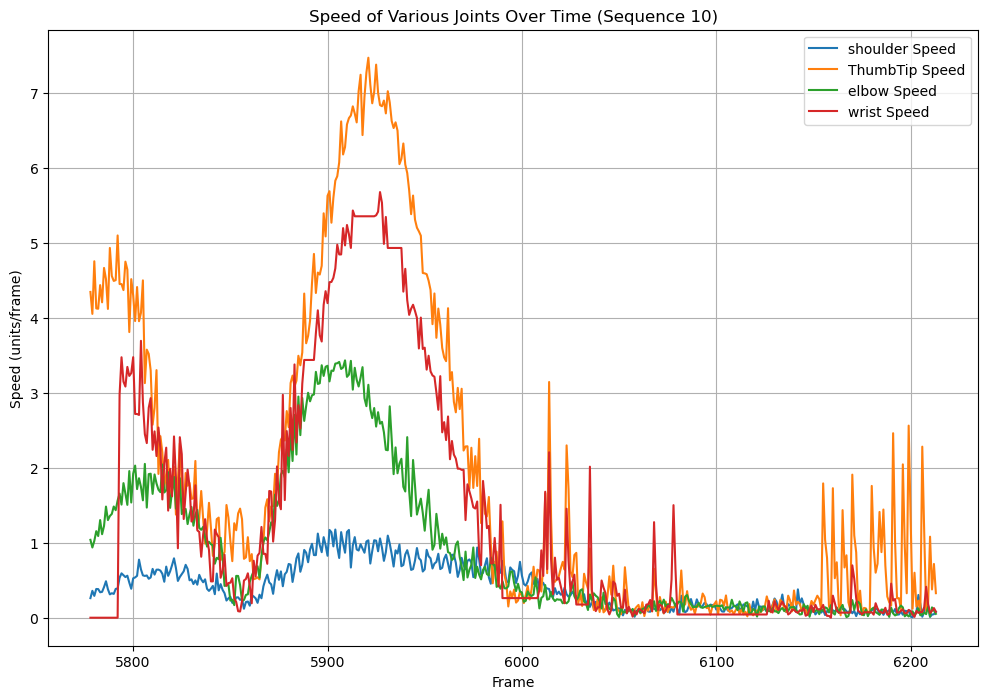

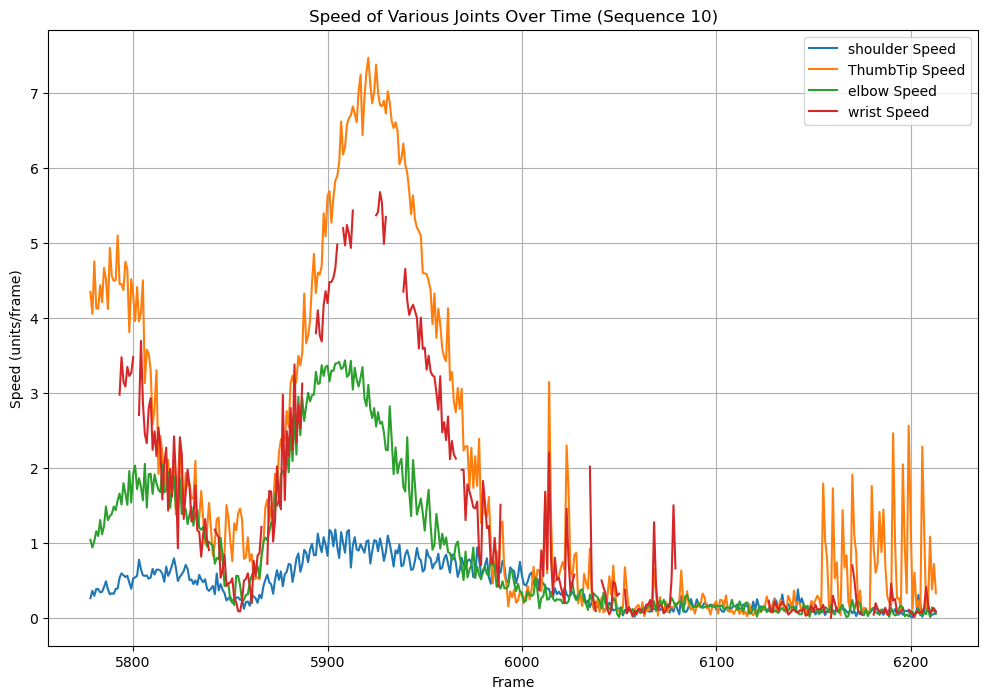

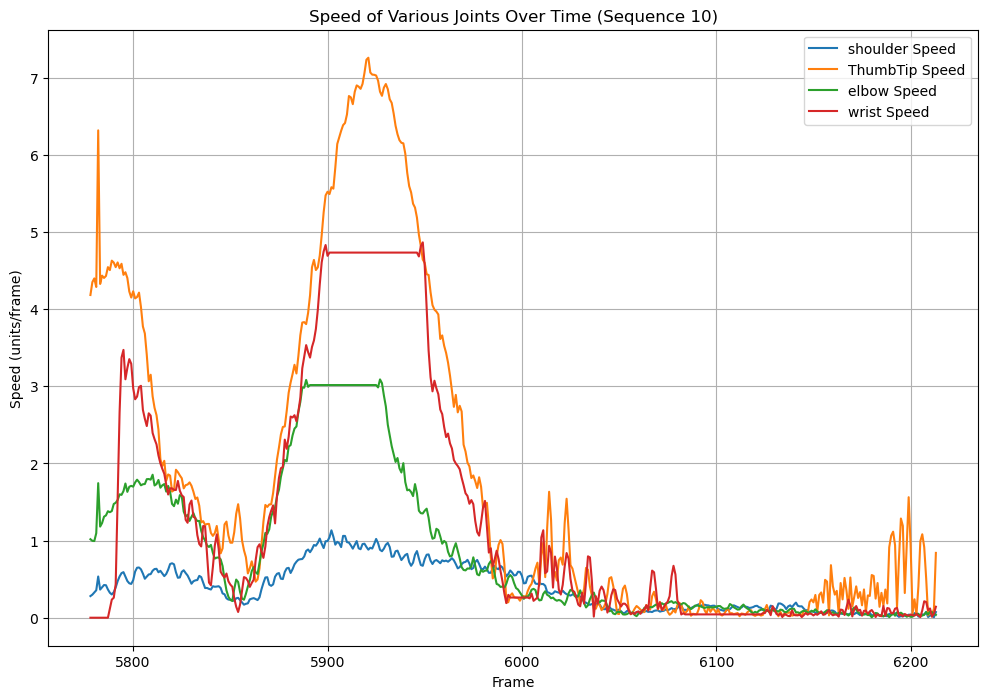

In [24]:
trajectories_smoothed = smooth_motion_data(trajectories_cleaned, method='savitzky_golay', window_length=10, polyorder=5)
plot_joint_speeds(trajectories_interpolated, 10)
plot_joint_speeds(trajectories, 10)
plot_joint_speeds(trajectories_smoothed, 10)

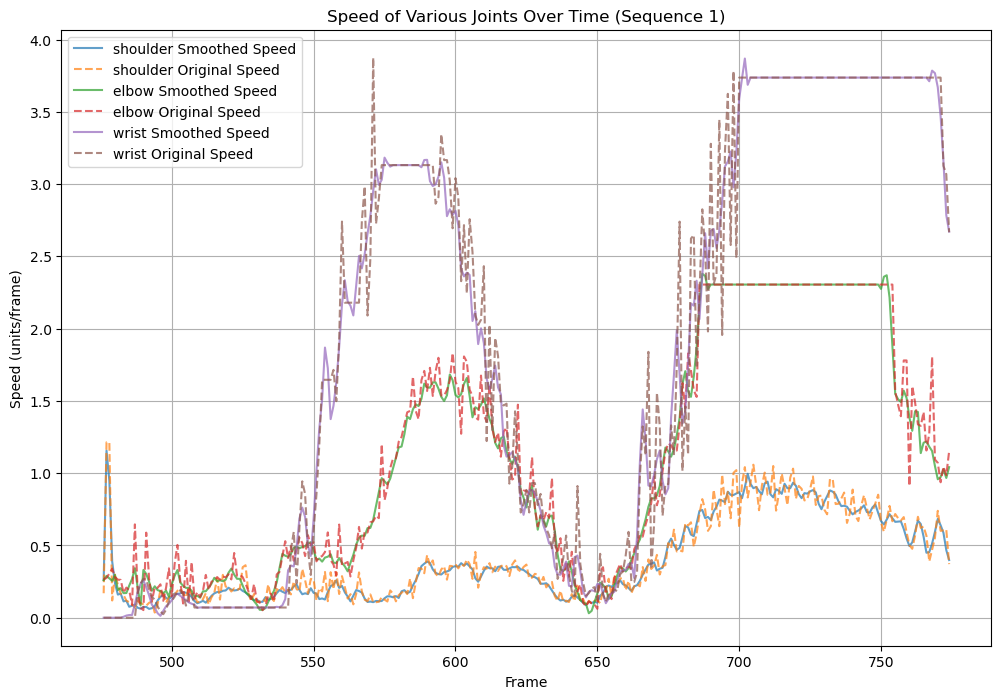

In [25]:
# Example usage: Visualizing the speeds of 'shoulder' and 'elbow' for sequence 1
plot_joint_speeds_compare(trajectories_cleaned, trajectories_smoothed, sequence_idx=1, joint_names=['wrist', 'shoulder', "elbow"], max_frames=300)


In [26]:
trajectories_smoothed.to_csv("csv_new/processed_Trajectories.csv", index=False)